In [1]:
import pandas as pd
import sklearn as sk
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from plotnine import *
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
%matplotlib inline

from aequitas.group import Group
from aequitas.bias import Bias

/usr/local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def clean_xs(data):
    to_dummy = ["race","marital-status", "sex", 'workclass','occupation']
    data = pd.get_dummies(data, columns=to_dummy)
    
    to_drop = ['education', 'relationship', 'native-country']
    
    data = data.drop(to_drop, axis=1)
    
    return data


In [23]:
data

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,outcome
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


In [27]:
#Data source: https://archive.ics.uci.edu/ml/datasets/adult

data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data", 
            header=None, sep= ', ',
            names=["age", "workclass",  "fnlwgt", "education", "education-num","marital-status","occupation","relationship","race","sex","capital-gain","capital-loss","hours-per-week","native-country","outcome"])



y = data['outcome']
X = data.drop('outcome', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

X_test_raw = X_test

X_train = clean_xs(X_train)
X_test = clean_xs(X_test)

# Some data cuts leave rare groups out of test due to dummyifying:
not_in_test = [X for X in X_train.columns if X not in X_test.columns]
for col in not_in_test:
    if all(True for lab in df['label_value'] if lab in (0,1)):
        X_test[col] = 0
    else:
        raise "Test set missing non-boolean column"

# an alternative is to drop
# X_train = X_train.drop(not_in_test, axis=1)

def output(model, X = X_test_raw, y_test = y_test, X_test = X_test):
    try:
        score = model.predict_proba(X_test)[:,0]
    except:
        if type(model) == sklearn.svm.classes.SVC:
            score = model.decision_function(X_test)
        else:
            raise "Unknown Score Function"
   
    return set_ranks( pd.DataFrame({ 'entity_id': pd.Series(y_test.index, index=y_test.index),
                 'score': score,
                 'label_value': [1 if a.strip() == ">50K" else 0 for a in y_test],
                 'gender': X['sex'],
                  'race': X['race'],
                'education': X['education'],
                'as_of_date': X.index # filler
                 }) )

def set_ranks(df):
    '''
    df is a data frame with a column called score
    '''
    
    N = df.shape[0]
    rank_abs = pd.Series(range(N), 
                      index = df.sort_values(by = "score", ascending=False).index,
                      name = "rank_abs") + 1
    rank_pct = 1 -  (rank_abs / N)
    rank_pct.name = "rank_pct"
    return pd.concat([df, rank_abs, rank_pct], axis=1, join_axes=[df.index])


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """


# Data exploration

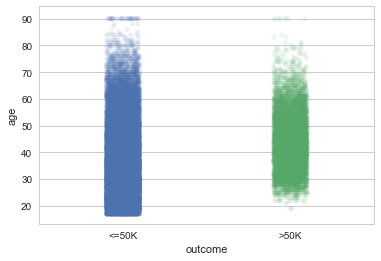

In [28]:
sns.stripplot(x="outcome", y="age", data=data, jitter=True, alpha=.1);

In [ ]:
ggplot(aes(y='age', x='outcome', color='sex'), data=data) +  geom_point(aes(fill = "sex"), position=position_jitterdodge(0.2), alpha=.05)

In [ ]:
ggplot(aes(y='age', x='outcome', color='race'), data=data) +  geom_point(aes(fill = "race"), position=position_jitterdodge(0.2), alpha=.05)

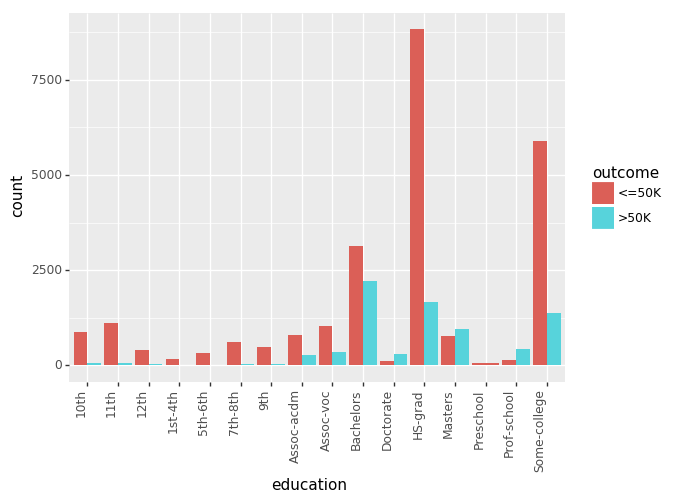

<ggplot: (-9223372036570588356)>

In [29]:
ggplot(aes(x='education', fill = 'outcome'), data=data) + geom_bar(position="dodge") + theme(axis_text_x = element_text(angle = 90, hjust = 1))

In [ ]:
N = data.shape[0]
g = pd.crosstab(data.outcome, data.sex)/ pd.crosstab(data.outcome, data.sex).sum()
# makes a series with a multi-index. # turns multi-index into columns
a = pd.DataFrame(g.unstack()).reset_index(inplace=False) 
a.rename(columns = {0:"percent"}, inplace=True)

In [ ]:
a

In [ ]:
ggplot(aes(x='sex', y='percent', fill = 'outcome'), data=a) + geom_bar(stat="identity") + theme(axis_text_x = element_text(angle = 90, hjust = 1))


In [ ]:
var = 'education'
N = data.shape[0]
g = pd.crosstab(data.outcome, data[var])/ pd.crosstab(data.outcome, data[var]).sum()
# makes a series with a multi-index. # turns multi-index into columns
a = pd.DataFrame(g.unstack()).reset_index(inplace=False) 
a.rename(columns = {0:"percent"}, inplace=True)

In [ ]:
ggplot(aes(x=var, y='percent', fill = 'outcome'), data=a) + geom_bar(stat="identity") + theme(axis_text_x = element_text(angle = 90, hjust = 1))


In [ ]:
pd.crosstab(y, 'outcome') #/N

In [66]:
# train models and get bias estimations, assumes data are a global variable.
def fit_model(model_type):
    '''
    model_type: sklearn model with fit and predict
    '''
    model = model_type
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("confusion matrix")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=["<=50K",">50K"]))
    return(model)

def get_aequitas(model, thresholds = { "rank_abs": [10, 50, 100],
              "rank_pct": [1.0, 2.0, 5.0, 10.0 ]}, ref_group_dict = {}, name="", path="",
              include_df=False, get_disparities=False, to_file = True):
    '''
    model: fit model from sklearn
    thresholds: dictionary with 'rank_abs' and 'rank_pct' as keys
    '''
    g = Group()

    thresholds = thresholds
    df = output(model)
    tabs = g.get_crosstabs(df, thresholds, 1)
    if not get_disparities:
        if include_df:
            return df, tabs
        return tabs
    else:
        b = Bias()
        try:
            model_name = str(type(model)).replace("\'>", "").split(".")[-1]
        except:
            model_name = ""
        #try:
        min_group = b.get_disparity_min_metric(tabs)
        majority = b.get_disparity_major_group(tabs)
        if ref_group_dict:
            pred  = b.get_disparity_predefined_groups(tabs, ref_group_dict)
        if to_file:
            min_group.to_csv(path + name + "_disparity_min_" +  model_name + ".csv")
            majority.to_csv(path + name + "_disparity_majority_" + model_name + ".csv")
            pred.to_csv(path + name + "_disparity_predifined_" + model_name + ".csv")
        if include_df:
            return df, (min_group, majority, pred)
        return (min_group, majority, pred)
#         except:
#             print("Could not get disparities metrics returning crosstabs instead")
#             if include_df:
#                 return df, tabs
#             return tabs
            

# Logistic Regression

In [73]:
get_aequitas(model, get_disparities=True, name="adult", path = "../demo/",\
             ref_group_dict={"education":"HS-grad", "race":"White", "gender":"Male"})

Feature Columns (Groups): ['education' 'gender' 'race']
COUNTS::: education
10th             292
11th             341
12th             116
1st-4th           45
5th-6th           79
7th-8th          183
9th              151
Assoc-acdm       303
Assoc-voc        406
Bachelors       1632
Doctorate        125
HS-grad         3214
Masters          481
Preschool         16
Prof-school      178
Some-college    2207
Name: entity_id, dtype: int64
COUNTS::: gender
Female    3199
Male      6570
Name: entity_id, dtype: int64
COUNTS::: race
Amer-Indian-Eskimo     100
Asian-Pac-Islander     303
Black                  967
Other                   73
White                 8326
Name: entity_id, dtype: int64
get_disparity_min_metric()
get_disparity_min_metric
get_disparity_major_group()
get_disparity_predefined_group()


(          TPR         group_value group_variable     k  model_id parameter  \
 0    0.000000                10th      education    10         1    10_abs   
 1    0.000000                11th      education    10         1    10_abs   
 2    0.000000                12th      education    10         1    10_abs   
 3    0.000000             1st-4th      education    10         1    10_abs   
 4    0.000000             5th-6th      education    10         1    10_abs   
 5    0.000000             7th-8th      education    10         1    10_abs   
 6    0.000000                 9th      education    10         1    10_abs   
 7    0.000000          Assoc-acdm      education    10         1    10_abs   
 8    0.000000           Assoc-voc      education    10         1    10_abs   
 9    0.004511           Bachelors      education    10         1    10_abs   
 10   0.000000           Doctorate      education    10         1    10_abs   
 11   0.000000             HS-grad      education   

In [75]:
ls ../demo

README.rst
adult_disparity_majority_LogisticRegression.csv
adult_disparity_min_LogisticRegression.csv
adult_disparity_predifined_LogisticRegression.csv
adult_prediciton_logit.csv
raw_data.csv


In [31]:
model = fit_model(LogisticRegression())

confusion matrix
[[7158  259]
 [1732  620]]
             precision    recall  f1-score   support

      <=50K       0.81      0.97      0.88      7417
       >50K       0.71      0.26      0.38      2352

avg / total       0.78      0.80      0.76      9769



In [32]:
df, results = get_aequitas(model, include_df=True)

Feature Columns (Groups): ['education' 'gender' 'race']
COUNTS::: education
10th             292
11th             341
12th             116
1st-4th           45
5th-6th           79
7th-8th          183
9th              151
Assoc-acdm       303
Assoc-voc        406
Bachelors       1632
Doctorate        125
HS-grad         3214
Masters          481
Preschool         16
Prof-school      178
Some-college    2207
Name: entity_id, dtype: int64
COUNTS::: gender
Female    3199
Male      6570
Name: entity_id, dtype: int64
COUNTS::: race
Amer-Indian-Eskimo     100
Asian-Pac-Islander     303
Black                  967
Other                   73
White                 8326
Name: entity_id, dtype: int64


In [ ]:
df.to_csv("../demo/adult_prediciton_logit.csv")

In [33]:
results.shape

(161, 26)

In [ ]:
results['PPR']

In [34]:
b = Bias()
b.get_disparity_major_group(results)

get_disparity_major_group()


,TPR,group_value,group_variable,k,model_id,parameter,TNR,FOmR,FDR,FPR,...,FDR_disparity,FOmR_disparity,FPR_disparity,FNR_disparity,PPR_ref_group_value,PPrev_ref_group_value,FDR_ref_group_value,FOmR_ref_group_value,FPR_ref_group_value,FNR_ref_group_value
0,0.000000,10th,education,10,1,10_abs,1.000000,0.061644,0.000000,0.000000,...,0.000000,0.396917,0.000000,1.000000,HS-grad,HS-grad,HS-grad,HS-grad,HS-grad,HS-grad
1,0.000000,11th,education,10,1,10_abs,1.000000,0.043988,0.000000,0.000000,...,0.000000,0.283235,0.000000,1.000000,HS-grad,HS-grad,HS-grad,HS-grad,HS-grad,HS-grad
2,0.000000,12th,education,10,1,10_abs,0.990741,0.069565,1.000000,0.009259,...,1.000000,0.447922,25.138889,1.000000,HS-grad,HS-grad,HS-grad,HS-grad,HS-grad,HS-grad
3,0.000000,1st-4th,education,10,1,10_abs,1.000000,0.044444,0.000000,0.000000,...,0.000000,0.286172,0.000000,1.000000,HS-grad,HS-grad,HS-grad,HS-grad,HS-grad,HS-grad
4,0.000000,5th-6th,education,10,1,10_abs,1.000000,0.050633,0.000000,0.000000,...,0.000000,0.326019,0.000000,1.000000,HS-grad,HS-grad,HS-grad,HS-grad,HS-grad,HS-grad
5,0.000000,7th-8th,education,10,1,10_abs,1.000000,0.038251,0.000000,0.000000,...,0.000000,0.246296,0.000000,1.000000,HS-grad,HS-grad,HS-grad,HS-grad,HS-grad,HS-grad
6,0.000000,9th,education,10,1,10_abs,1.000000,0.052980,0.000000,0.000000,...,0.000000,0.341133,0.000000,1.000000,HS-grad,HS-grad,HS-grad,HS-grad,HS-grad,HS-grad
7,0.000000,Assoc-acdm,education,10,1,10_abs,1.000000,0.287129,0.000000,0.000000,...,0.000000,1.848787,0.000000,1.000000,HS-grad,HS-grad,HS-grad,HS-grad,HS-grad,HS-grad
8,0.000000,Assoc-voc,education,10,1,10_abs,0.996503,0.296296,1.000000,0.003497,...,1.000000,1.907816,9.493007,1.000000,HS-grad,HS-grad,HS-grad,HS-grad,HS-grad,HS-grad
9,0.004511,Bachelors,education,10,1,10_abs,0.997932,0.406884,0.400000,0.002068,...,0.400000,2.619875,5.615305,0.995489,HS-grad,HS-grad,HS-grad,HS-grad,HS-grad,HS-grad


In [11]:
b.get_disparity_min_metric(results)

get_disparity_min_metric()
get_disparity_min_metric


,TPR,group_value,group_variable,k,model_id,parameter,TNR,FOmR,FDR,FPR,...,PPrev_disparity,PPrev_ref_group_value,FDR_disparity,FDR_ref_group_value,FOmR_disparity,FOmR_ref_group_value,FPR_disparity,FPR_ref_group_value,FNR_disparity,FNR_ref_group_value
0,0.000000,10th,education,10,1,10_abs,1.000000,0.061644,0.000000,0.000000,...,1.0,10th,1.000000,10th,10.000000,Preschool,1.0,10th,10.000000,Preschool
1,0.000000,11th,education,10,1,10_abs,1.000000,0.043988,0.000000,0.000000,...,1.0,10th,1.000000,10th,10.000000,Preschool,1.0,10th,10.000000,Preschool
2,0.000000,12th,education,10,1,10_abs,0.990741,0.069565,1.000000,0.009259,...,10.0,10th,10.000000,10th,10.000000,Preschool,10.0,10th,10.000000,Preschool
3,0.000000,1st-4th,education,10,1,10_abs,1.000000,0.044444,0.000000,0.000000,...,1.0,10th,1.000000,10th,10.000000,Preschool,1.0,10th,10.000000,Preschool
4,0.000000,5th-6th,education,10,1,10_abs,1.000000,0.050633,0.000000,0.000000,...,1.0,10th,1.000000,10th,10.000000,Preschool,1.0,10th,10.000000,Preschool
5,0.000000,7th-8th,education,10,1,10_abs,1.000000,0.038251,0.000000,0.000000,...,1.0,10th,1.000000,10th,10.000000,Preschool,1.0,10th,10.000000,Preschool
6,0.000000,9th,education,10,1,10_abs,1.000000,0.052980,0.000000,0.000000,...,1.0,10th,1.000000,10th,10.000000,Preschool,1.0,10th,10.000000,Preschool
7,0.000000,Assoc-acdm,education,10,1,10_abs,1.000000,0.287129,0.000000,0.000000,...,1.0,10th,1.000000,10th,10.000000,Preschool,1.0,10th,10.000000,Preschool
8,0.000000,Assoc-voc,education,10,1,10_abs,0.996503,0.296296,1.000000,0.003497,...,10.0,10th,10.000000,10th,10.000000,Preschool,10.0,10th,10.000000,Preschool
9,0.004511,Bachelors,education,10,1,10_abs,0.997932,0.406884,0.400000,0.002068,...,10.0,10th,10.000000,10th,10.000000,Preschool,10.0,10th,10.000000,Preschool


In [19]:
pd.crosstab(results.group_variable,results.group_value)

group_value,10th,11th,12th,1st-4th,5th-6th,7th-8th,9th,Amer-Indian-Eskimo,Asian-Pac-Islander,Assoc-acdm,...,Doctorate,Female,HS-grad,Male,Masters,Other,Preschool,Prof-school,Some-college,White
group_variable,,,,,,,,,,,,,,,,,,,,,
education,7,7,7,7,7,7,7,0,0,7,...,7,0,7,0,7,0,7,7,7,0
gender,0,0,0,0,0,0,0,0,0,0,...,0,7,0,7,0,0,0,0,0,0
race,0,0,0,0,0,0,0,7,7,0,...,0,0,0,0,0,7,0,0,0,7


In [36]:
results[results.group_value=="White"]

,TPR,group_value,group_variable,k,model_id,parameter,TNR,FOmR,FDR,FPR,...,PPrev,FP,FN,TN,TP,group_label_neg,group_label_pos,group_size,total_entities,Prev
154,0.001413,White,race,10,1,10_abs,0.999516,0.254808,0.500000,0.000484,...,0.000721,3,2120,6200,3,6203,2123,8326,9769,0.254984
155,0.004239,White,race,50,1,50_abs,0.995486,0.255037,0.756757,0.004514,...,0.004444,28,2114,6175,9,6203,2123,8326,9769,0.254984
156,0.007537,White,race,100,1,100_abs,0.990650,0.255332,0.783784,0.009350,...,0.008888,58,2107,6145,16,6203,2123,8326,9769,0.254984
157,1.000000,White,race,9769,1,1.0_pct,0.000000,0.000000,0.745016,1.000000,...,1.000000,6203,0,0,2123,6203,2123,8326,9769,0.254984
158,1.000000,White,race,9769,1,2.0_pct,0.000000,0.000000,0.745016,1.000000,...,1.000000,6203,0,0,2123,6203,2123,8326,9769,0.254984
159,1.000000,White,race,9769,1,5.0_pct,0.000000,0.000000,0.745016,1.000000,...,1.000000,6203,0,0,2123,6203,2123,8326,9769,0.254984
160,1.000000,White,race,9769,1,10.0_pct,0.000000,0.000000,0.745016,1.000000,...,1.000000,6203,0,0,2123,6203,2123,8326,9769,0.254984


In [37]:
b.get_disparity_predefined_groups(results, {"education":"HS-grad", "race":"White", "gender":"Male"})

get_disparity_predefined_group()


,TPR,group_value,group_variable,k,model_id,parameter,TNR,FOmR,FDR,FPR,...,FDR_disparity,FOmR_disparity,FPR_disparity,FNR_disparity,PPR_ref_group_value,PPrev_ref_group_value,FDR_ref_group_value,FOmR_ref_group_value,FPR_ref_group_value,FNR_ref_group_value
0,0.000000,10th,education,10,1,10_abs,1.000000,0.061644,0.000000,0.000000,...,0.000000,0.396917,0.000000,1.000000,HS-grad,HS-grad,HS-grad,HS-grad,HS-grad,HS-grad
1,0.000000,11th,education,10,1,10_abs,1.000000,0.043988,0.000000,0.000000,...,0.000000,0.283235,0.000000,1.000000,HS-grad,HS-grad,HS-grad,HS-grad,HS-grad,HS-grad
2,0.000000,12th,education,10,1,10_abs,0.990741,0.069565,1.000000,0.009259,...,1.000000,0.447922,25.138889,1.000000,HS-grad,HS-grad,HS-grad,HS-grad,HS-grad,HS-grad
3,0.000000,1st-4th,education,10,1,10_abs,1.000000,0.044444,0.000000,0.000000,...,0.000000,0.286172,0.000000,1.000000,HS-grad,HS-grad,HS-grad,HS-grad,HS-grad,HS-grad
4,0.000000,5th-6th,education,10,1,10_abs,1.000000,0.050633,0.000000,0.000000,...,0.000000,0.326019,0.000000,1.000000,HS-grad,HS-grad,HS-grad,HS-grad,HS-grad,HS-grad
5,0.000000,7th-8th,education,10,1,10_abs,1.000000,0.038251,0.000000,0.000000,...,0.000000,0.246296,0.000000,1.000000,HS-grad,HS-grad,HS-grad,HS-grad,HS-grad,HS-grad
6,0.000000,9th,education,10,1,10_abs,1.000000,0.052980,0.000000,0.000000,...,0.000000,0.341133,0.000000,1.000000,HS-grad,HS-grad,HS-grad,HS-grad,HS-grad,HS-grad
7,0.000000,Assoc-acdm,education,10,1,10_abs,1.000000,0.287129,0.000000,0.000000,...,0.000000,1.848787,0.000000,1.000000,HS-grad,HS-grad,HS-grad,HS-grad,HS-grad,HS-grad
8,0.000000,Assoc-voc,education,10,1,10_abs,0.996503,0.296296,1.000000,0.003497,...,1.000000,1.907816,9.493007,1.000000,HS-grad,HS-grad,HS-grad,HS-grad,HS-grad,HS-grad
9,0.004511,Bachelors,education,10,1,10_abs,0.997932,0.406884,0.400000,0.002068,...,0.400000,2.619875,5.615305,0.995489,HS-grad,HS-grad,HS-grad,HS-grad,HS-grad,HS-grad


In [ ]:
ggplot(aes(x="group_value"), \
       data = results[results.group_variable=='race'][results.k==100]) +\
    geom_bar(aes( y='TPR'), stat="identity") +\
    theme(axis_text_x = element_text(angle = 90, hjust = 1))

In [ ]:
results.columns

In [ ]:
ggplot(aes(y='age', x='outcome', color='race'), data=results) +  geom_point(aes(fill = "race"), position=position_jitterdodge(0.2), alpha=.05)




In [ ]:
results.to_csv("../demo/logistic_crosstab.csv")

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = fit_model(RandomForestClassifier())

In [ ]:
results = get_aequitas(model)

In [ ]:
get_disparity_min_metric(results)

In [ ]:
results.to_csv("../demo/random_forest_crosstab.csv")

# SVM

In [ ]:
model = fit_model(sk.svm.SVC(C=10,probability=True))

In [ ]:
Test counts
Make pictures of results against models.